# **Using Data Science for Card Design in Magic: The Gathering** 

<center>
<img src="https://img.evbuc.com/https%3A%2F%2Fcdn.evbuc.com%2Fimages%2F95635997%2F424455803869%2F1%2Foriginal.20200306-012450?w=1000&auto=format%2Ccompress&q=75&sharp=10&rect=0%2C60%2C1920%2C960&s=5fd37725aa8247833df06f42b908d745" alt="drawing" width="650"/>
</center>

## **Introduction**
The goal of this tutorial is to walk through the basic data science pipeline. To do this we chose to analyze some potentially interesting relationships of creature characteristics in Magic: The Gathering, hereafter referred to as MTG. Using this, we hope to glean information about how Wizards of the Coast values things like a creature's power or abilities when deciding a creature's converted mana cost.

## **Game Terminology**

Before we get into the code, we will explain some helpful game terminology. In order to cast a spell, a certain amount of mana must be payed. This amount depends on the card, and can generally be seen at the top right of the card. This amount can be summarized in the converted mana cost, or CMC, of the card, which is just the total number of mana needed.
<center>
<img src="https://img.scryfall.com/cards/large/front/0/3/036ef8c9-72ac-46ce-af07-83b79d736538.jpg?1562730661" alt="drawing" width="200"/>
</center>

Each card also has a color, which is intended to reflect its inteded gameplay philosophy. For example, red is generally associated with aggression and chaos, while white is generally associated order and morality. Cards are also not restricted to just one color. There are cards that are all 5 colors and some that are none. These colors also have certain abilities called "keywords" associated with them. These change how the card functions. For example, white is associated with "Flying", which means that when a creature attacks, it cannot be blocked by creatures that do not have flying. Obviously, these abilities can improve or impair the cards functions depending on the word.

Creatures are a specific type of spell that remain on the battlefield and have a power and toughness. They can additionally have abilities in their text box. These can include keywords, as mentioned above, among other abilities.
<center>
<img src="https://img.scryfall.com/cards/large/front/d/2/d28056c7-c58d-4986-a45c-c9e55aed23a1.jpg?1555040601" alt="drawing" width="200"/>
</center>

When creating cards, designers ideally allow cards to have a certain amount of strength for their given cost. If they have too much strength, they will quickly dominate the competitive format. If they have too little, they will not be used at all. This is a tight balance, as designers will also have to predict how players will use cards together so that they can control synergistic effects. 

For reference, Black, Blue, Green, Red, and Red, will be referred to as B,U,G,R, and W for the rest of this tutorial. This is by standard Magic conventions.
Also, for a more detailed rule explanation, see the simplified MTG rulebook  [here](https://media.wizards.com/images/magic/resources/rules/EN_MTGM14_PrintedRulebook_LR.pdf).

## **Data Preperation**

Before we can explore the data, we need to get it into a format we can work with. Thankfully, MTGJSON is an open-source project that has all MTG cards ever printed in a JSON file with all relevant information we need. We parsed through this JSON file to create a Pandas dataframe with all information we needed. 

In this tutorial we focus only on Creature spells in our analysis for simplicity. Furthermore we focus on the following creature attributes and abilities:

*   Vigilance
*   Trample
*   Deathtouch
*   Haste
*   Lifelink
*   First Strike
*   Defender
*   Flying
*   Color
*   Power
*   Toughness

Other keywords were ignored just due to simplicity and all other abilities were ignored due to our inability to properly parse them. This will obviously have an effect on our analysis, but we should be able to discern some general trends and hopefully be able to perform classification using machine learning.



In [0]:
import json
import numpy as np
import pandas as pd

with open('sets.json') as json_file:
    data = json.load(json_file)

First we filter out all the sets that were never [Standard-legal](https://magic.wizards.com/en/content/standard-formats-magic-gathering). We then go through each card, cutting out all of the cards which aren't creatures and cut out any text or keywords which we aren't going to be using in our analysis. We also cut out creatures with a CMC of 0, or a power/toughness of 0/0. Because we got our data from a JSON file, we need to first convert the data into a python dictionary list.

In [0]:
rows = []
for set_name in data.keys(): # for each set
    sets = data[set_name]
    # only use certain sets
    if (sets['type'] == 'core' or sets['type'] == 'expansion'): 
        date = sets['releaseDate']
        cards = sets['cards']
        for card in cards:
            # only pick out creatures with specific 
            # attributes for this analysis
            if 'Creature' in card['types'] and '*' not in card['power'] and '*' not in card['toughness'] and not ('0' in card['toughness'] and '0' in card['power']) and 0 != card['convertedManaCost']:
                card['date'] = date
                for color in ['G','U','B','R','W']:
                    card[color] = 0
                for color in card['colorIdentity']:
                    card[color] = 1
                if 'text' in card.keys():
                    text = card['text']
                else:
                    text = ''
                # add keyword data
                for keyword in ['Flying', 'Deathtouch', 'Trample', 'Vigilance', 'Haste', 'Lifelink', 'First strike', 'Defender']:
                    if keyword in text or ', ' + keyword.lower() in text:
                        card[keyword.lower()] = 1
                    else:
                        card[keyword.lower()] = 0
                rows.append(card)
            

Next we convert the python dictionary into a Pandas dataframe. We're going to be using this dataframe for the rest of the project for easier data transformation and access. 

In [0]:
# create the data frame and type corrections
card_df = pd.DataFrame.from_dict(rows, orient = 'columns')

Now that we have the data in a Pandas dataframe, we want to change some of the rows to be more useful when we're going to be performing our analysis. Here we transforms the power and toughness columns from string to numerical values, and then combine the values in these columns to a new column called stats.

In [0]:
card_df['power'] = pd.to_numeric(card_df['power'])
card_df['toughness'] = pd.to_numeric(card_df['toughness'])
card_df['stats'] = card_df['power'] + card_df['toughness']


Again we need to convert columns from string types to numeric values that we can use in our analysis. Below you can see the new dataframe which we'll be using for analysis.

In [0]:
card_df['convertedManaCost'] = card_df['convertedManaCost'].astype(int)
card_df['stats_per_cmc'] = card_df['stats']/card_df['convertedManaCost'].astype(float)
card_df['date'] = pd.to_datetime(card_df['date']).astype(int) / (10**10)

cards_df = card_df[['name', 'colorIdentity', 'convertedManaCost', 'edhrecRank', 'power', 'toughness', 'prices', 'rarity', 'date', 'stats','stats_per_cmc', 'flying', 'deathtouch', 'trample', 'vigilance', 'haste', 'lifelink', 'first strike', 'defender', 'U','G','B','R','W']]
cards_df

,name,colorIdentity,convertedManaCost,edhrecRank,power,toughness,prices,rarity,date,stats,stats_per_cmc,flying,deathtouch,trample,vigilance,haste,lifelink,first strike,defender,U,G,B,R,W
0,Academy Researchers,[U],3,10928.0,2,2,"{'mtgo': {'2020-05-11': 0.03}, 'mtgoFoil': {'2...",uncommon,118428480.0,4,1.333333,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Air Elemental,[U],5,11152.0,4,4,"{'mtgo': {}, 'mtgoFoil': {}, 'paper': {}, 'pap...",uncommon,118428480.0,8,1.600000,1,0,0,0,0,0,0,0,1,0,0,0,0
2,Air Elemental,[U],5,11152.0,4,4,"{'mtgo': {'2020-05-11': 0.03}, 'mtgoFoil': {'2...",uncommon,118428480.0,8,1.600000,1,0,0,0,0,0,0,0,1,0,0,0,0
3,Ambassador Laquatus,[U],3,8430.0,1,3,"{'mtgo': {'2020-05-11': 0.02}, 'mtgoFoil': {'2...",rare,118428480.0,4,1.333333,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Anaba Bodyguard,[R],4,14386.0,2,3,"{'mtgo': {}, 'mtgoFoil': {}, 'paper': {}, 'pap...",common,118428480.0,5,1.250000,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12290,Warren Instigator,[R],2,3059.0,1,1,"{'mtgo': {'2020-05-11': 0.86}, 'mtgoFoil': {'2...",mythic,125444160.0,2,1.000000,0,0,0,0,0,0,0,0,0,0,0,1,0
12291,Welkin Tern,[U],2,15750.0,2,1,"{'mtgo': {'2020-05-11': 0.05}, 'mtgoFoil': {'2...",common,125444160.0,3,1.500000,1,0,0,0,0,0,0,0,1,0,0,0,0
12292,Windrider Eel,[U],4,12155.0,2,2,"{'mtgo': {'2020-05-11': 0.04}, 'mtgoFoil': {'2...",common,125444160.0,4,1.000000,1,0,0,0,0,0,0,0,1,0,0,0,0
12293,World Queller,[W],5,7250.0,4,4,"{'mtgo': {'2020-05-11': 0.02}, 'mtgoFoil': {'2...",rare,125444160.0,8,1.600000,0,0,0,0,0,0,0,0,0,0,0,0,1


## **Data Analysis**
Now that we have our data in a workable format, we can try and see some interesting things. First, lets run a simple linear regression to see how much various aspects of a card are worth.

In [0]:
import statsmodels.formula.api as sm 
import matplotlib.pyplot as plt

# create a simple linear regression model predicting convertedManaCost based off date and different abilities
simple_res = sm.ols('convertedManaCost~flying+trample+haste+vigilance+defender+power+toughness+date', data=cards_df).fit()
simple_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      convertedManaCost   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2605.
Date:                Tue, 19 May 2020   Prob (F-statistic):               0.00
Time:                        01:28:21   Log-Likelihood:                -17645.
No. Observations:               12295   AIC:                         3.531e+04
Df Residuals:                   12286   BIC:                         3.537e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8899      0.045     41.768      0.000       1.801       1.979
flying         0.4361      0.024     18.223      0.000       0.389       0.483
trample       -0.2582      0.048     -5.331      0.000      -0.353      -0.163
haste          0.1260      0.055      2.297      0.022       0.018       0.234
vigilance      0.1166      0.060      1.958      0.050      -0.000       0.233
defender      -0.7160      0.058    -12.333      0.000      -0.830      -0.602
power          0.4344      0.008     52.556      0.000       0.418       0.451
toughness      0.4270      0.008     52.585      0.000       0.411       0.443
date       -5.486e-09   3.62e-10    -15.150      0.000    -6.2e-09   -4.78e-09
==============================================================================
Omnibus:                     1264.244   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10773.330
Skew:                          -0.006   Prob(JB):                         0.00
Kurtosis:                       7.586   Cond. No.                     8.02e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.02e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There are some pretty interesting results here. The most noticeable one is the negative date coefficient. This implies that the cost of creatures with the same cost are cheaper the later they are printed. This solidifies the idea of power creep, especially considering the P>T is essentially 0. Another very interesting thing was to see the predicted value of keywords. For the most part, they are roughly what we expected. The one exception, however, is trample. Trample allows creatures to deal damage to your opponent if they are blocked by a creature with toughness lower than your power, a strictly positive keyword. It has a negative coefficient, however, meaning that cards with trample are cheaper than the same card without trample on average. Upon some reflection on why that is, it is not super surprising. Trample is a primarily green keyword and green is the color associated with big creatures, so they generally have larger power/toughness than creatures of the same CMC but different colors. 

It is of note that all coefficients are statistically significant, likely due to the sample size.


It could be interesting to see how this model changes if we add interacting terms between these and colors, but there are so many variables that it would be difficult to make sense of in a meaningful way.

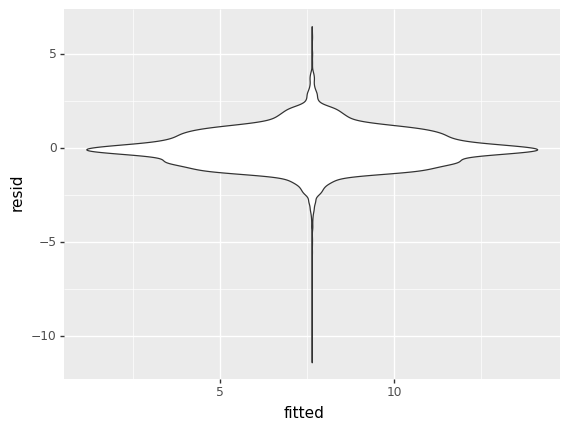

<ggplot: (-9223363243008001378)>

In [0]:
# create copy data frame to add fitted and residuals data to
copy_df = cards_df.copy()
copy_df['fitted'] = simple_res.fittedvalues
copy_df['resid'] = simple_res.resid

# plot residuals
ggplot(copy_df, aes('fitted', 'resid')) + geom_violin()

We plotted the residuals in the violin plot just to see how well our regression actually performed and it seems to have done fairly well. It is pretty normalized and the spread is fairly low. 

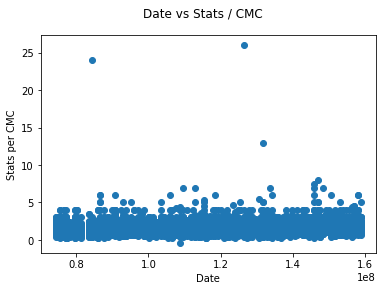

In [0]:
fig = plt.figure()
plt.scatter(cards_df['date'], cards_df['stats_per_cmc'])
fig.suptitle('Date vs Stats / CMC')
plt.xlabel('Date')
plt.ylabel('Stats per CMC')
fig.show()

We also wanted a quick comparison of stats per CMC over time, to see if we could see any clear trends. Visually, there is not much. The outliers here provide some clear drawbacks caused by inability to parse card text. The highest point is a good example. This card is Death's Shadow.
<center>
<img src="https://img.scryfall.com/cards/large/front/9/d/9ddf501c-af11-4e97-81f7-32c9ee384a27.jpg?1561766551" alt="drawing" width="200"/>
</center>
In most formats, players start with 20 life. This clearly has an impact on the stats of Death's Shadow. However, since we cannot parse the effect of the card, we have no way of taking this into account. Thankfully, there are very few cases that are as significant as this. Lets plot a regression line to see if there are any underlying trends. 

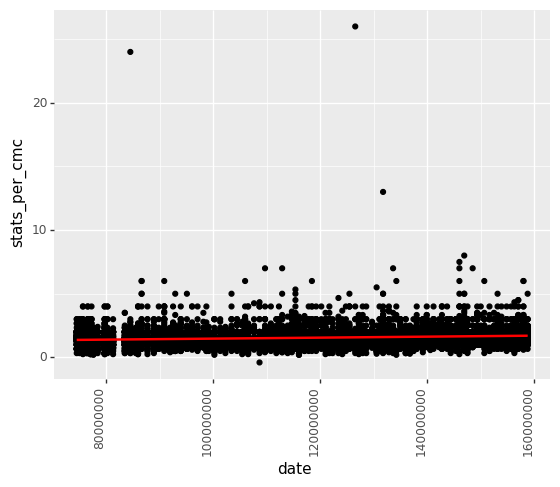

<ggplot: (8793844673512)>

In [0]:
# creates graph of date vs stats per cmc
(ggplot(cards_df, aes(x='date', y='stats_per_cmc')) 
 + geom_point() + geom_smooth(method='lm', color = "red") + theme(axis_text_x  = element_text(angle = 90, hjust = 1)))

Here we can see a slight increase in stats_per_cmc as date increases. This agrees with the more detailed regression as well. Altogether though, this graph is fairly unhelpful. Let's make a graph to better see the distribution of card stats by CMC.

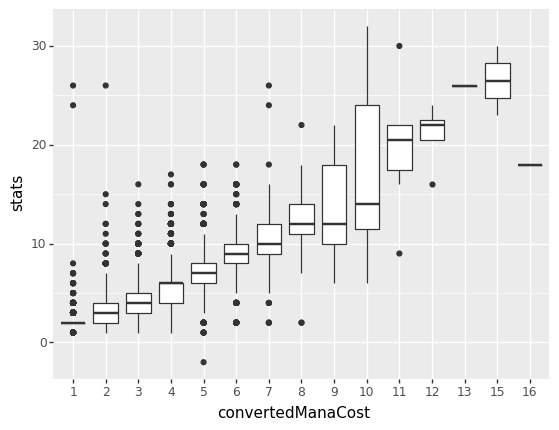

<ggplot: (8793855185423)>

In [0]:
from plotnine import *
# use the plotnine module for ggplot graphics

# create boxplot of cmc vs stats
ggplot(cards_df, aes(x='factor(convertedManaCost)', y='stats')) + geom_boxplot() + labs(x='convertedManaCost')

In this graph, we can see the distribution of stats for a each given CMC. Here we can see the number of outliers a little better, but its still a little limited given that stats is a discrete value. What we can see clearly is a general trend of stats increasing as CMC increases. Does efficiency change as CMC changes? We should expect to see two effects. The first effect is to see very efficient 1 CMC creatures. This is because players are generally limited to only the cards in their hand, so while their efficiency may be high, they come with an opportunity cost because they are still worse on average than higher CMC creatures. The second effect is that we should expect to see high CMC creatures to be more efficient. Players are also limited by the number of turns they have to play the game. If you wait 9 turns to play a card, it is possible to have already lost, so cards that are expensive need to have a significant effect on the game.

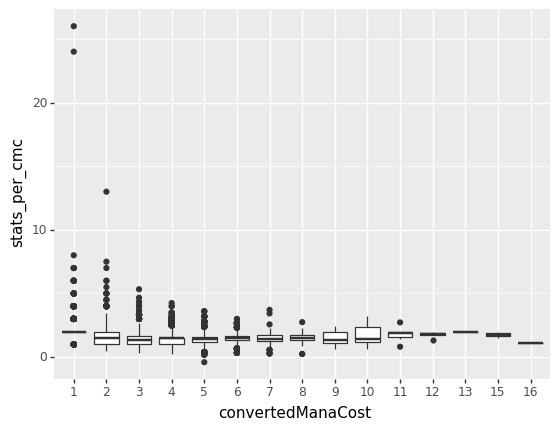

<ggplot: (8793822083462)>

In [0]:
ggplot(cards_df, aes(x='factor(convertedManaCost)', y='stats_per_cmc')) + geom_boxplot() + labs(x='convertedManaCost')

This graph is pretty interesting. We can see the large variance in low CMC statlines and how it gradually decreases as CMC increases. This could also just be an artefact of how we are looking at the data. Since we are normalizing using CMC, the distribution is inherently reduced as CMC increases. Furthermore, there are much more low CMC creatures than higher CMC creatures.
Something we have not explored yet is how color identity affects stats and CMC.

Let's turn the color identity array into a single string and see some plots.

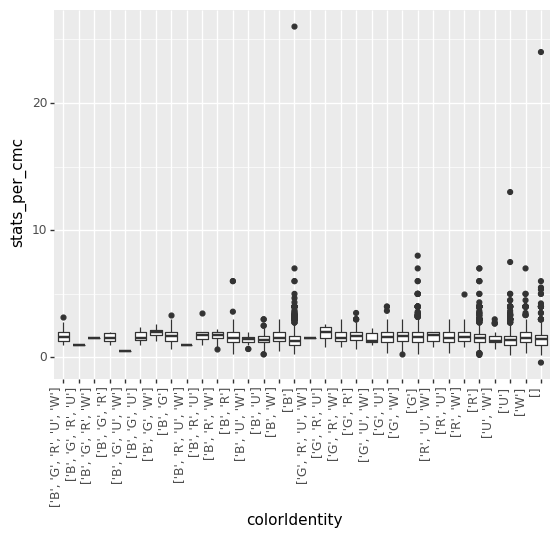

<ggplot: (8793803057626)>

In [0]:
# copies the dataframe to change for this graph
graph_copy = cards_df.copy()[['stats','stats_per_cmc', 'colorIdentity', 'convertedManaCost']]
graph_copy['colorIdentity'] = graph_copy['colorIdentity'].astype(str)

ggplot(graph_copy, aes(x='colorIdentity', y='stats_per_cmc')) + geom_boxplot() + theme(axis_text_x  = element_text(angle = 90, hjust = 1)) + labs(x='colorIdentity')

There is not a ton to this graph. The main noticeable is that all the single color graphs as well as colorless has much more variance compared to the other color combinations. 

 # **Machine Learning**
 After exploring some of the properties of MTG we will now try to set up some machine learning experiments on the data. This will be done using the sklearn library. 
We will first create an experiment to see whether KNN or random forests are a better clasification method for determining the flying attribute in cards. We will use 5 fold cross validation to get roc and auc data.
<br><br>
To learn more about any of the topics in this tutorial, follow the links below:<br>

[sklearn random forest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
<br>
[sklearn knn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
<br>
[what is a random forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)<br>
[what is knn](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)<br>
[what is k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/)





In [0]:
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
# imports needed for ml 

Because the sklearn module does not deal well with non numeric data, we drop the unused columns to allow us to use numpy to create arrays we can feed into the sklearn modules.

In [0]:
# updating data frame for ml section 
cards_df = cards_df.drop(['name', 'colorIdentity', 'prices', 'rarity'], axis = 1)
# sklearn works with number data so drop all non numeric columns
cards_df = cards_df.dropna(axis=0) # drop all na rows

# input for the classification task (all columns but the ability we try to predict)
X = cards_df.drop(['flying'], axis=1).to_numpy()

# values to predict
y = cards_df['flying'].to_numpy()

Here we will create the two clasifiers used in our experiment as well as define a function for getting and returning the roc and auc data for the experiment. We set up a grid search 5 fold cross validation so that we can assess the classifiers over a range of parameters. 

In [0]:
# create random forest and knn classifiers for the experiment
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=30)
knn = KNeighborsClassifier(n_neighbors=5)

# parameters to try for the random forest model 
# will try all values in the list and determine which is best
parameters = {'max_features': [2,6, 11, 18]}
rf_cv = sklearn.model_selection.GridSearchCV(rf, parameters, cv=5)

# parameters to try for the knn model
# will try all values in the range and determine which is best
parameters = {'n_neighbors': np.arange(3,20)}
knn_cv = sklearn.model_selection.GridSearchCV(knn, parameters, cv=5)


# following sklearn tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=5)

# function to get the roc data from a model
def get_roc_data(model, cv_obj, Xdat = X, Ydat = y):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(Xdat, Ydat)):
        model.fit(Xdat[train], Ydat[train])
        scores = model.predict_proba(Xdat[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(Ydat[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df

Now that we have defined a way to obtain roc and auc data, we will collect the data based on the two different classifiers and store them to create a data frame to be used to graph the two roc curves. 

In [0]:
# get data for the random forest model
rf_curve_df, rf_auc_df = get_roc_data(rf_cv, cv_obj)
rf_curve_df['model'] = 'random forest'
rf_auc_df['model'] = 'random forest'

In [0]:
# get data for the knn model
knn_curve_df, knn_auc_df = get_roc_data(knn_cv, cv_obj)
knn_curve_df['model'] = 'nearest neighbors'
knn_auc_df['model'] = 'nearest neighbors'

In [0]:
# create data frame to graph roc curves
curve_df = pd.concat([rf_curve_df, knn_curve_df])

After calculating and storing the roc data for each model, we will display the two roc curves to determine which classifier did better at this task. Curves that have a low false positive rate and a high true positive rate are considered the best curves.

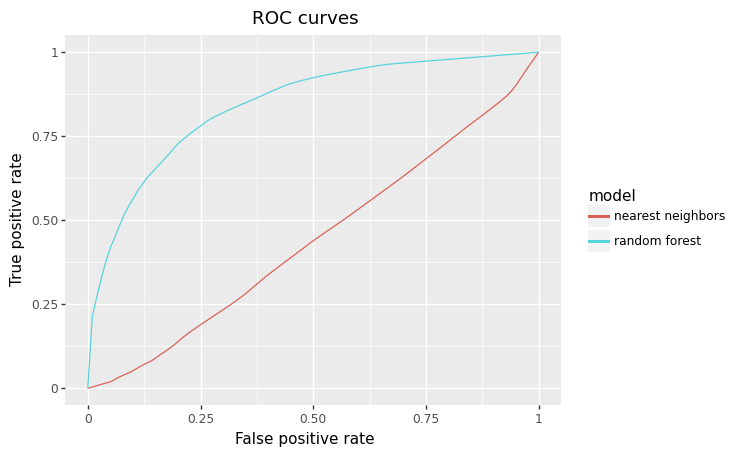

<ggplot: (8735564204720)>

In [0]:
# graph roc curves
mean_curve_df = curve_df.groupby(['model','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line() +
    labs(title = "ROC curves",
         x = "False positive rate",
         y = "True positive rate"))

Here we can see that the random forest model does significantly better than the nearest neighbor model in identifying cards which have the flying attribute. We can confirm this by looking at the graph of estimates of the auc and creating a linear model of the two auc estimates to determine if one model does better by a statistically significant margin. Given the roc graphs, we can predict that the random forest model will have a much higher auc estimate.

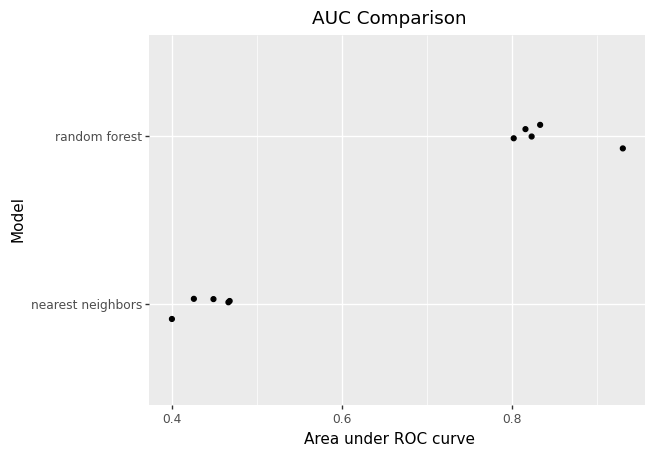

<ggplot: (-9223363274497644982)>

In [0]:
# data frame for auc data
auc_df = pd.concat([knn_auc_df, rf_auc_df])

# graph auc data of both models
(ggplot(auc_df, aes(x='model', y='auc')) + 
  geom_jitter(position=position_jitter(0.1)) + 
  coord_flip() + 
  labs(title = "AUC Comparison", 
  x="Model",
  y="Area under ROC curve"))

In [0]:
# create linear regression between auc of both models
lm_fit = sm.ols('auc~model', data=auc_df).fit()
lm_fit.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     230.3
Date:                Sat, 16 May 2020   Prob (F-statistic):           3.52e-07
Time:                        19:29:48   Log-Likelihood:                 18.747
No. Observations:                  10   AIC:                            -33.49
Df Residuals:                       8   BIC:                            -32.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4420      0.019     23.815      0.000       0.399       0.485
model[T.random forest]     0.3983      0.026     15.176      0.000       0.338       0.459
==============================================================================
Omnibus:                        6.054   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                2.362
Skew:                           1.142   Prob(JB):                        0.307
Kurtosis:                       3.670   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As predicted, the auc estimates for the random forest model were significantly higher than the auc estimates for nearest neighbors. Using linear regression, we can see that the p value of the random forest term is less than 0.05. This signifies that the random forest model is superior by a statistically significant margin.<br><br>
Now, knowing that the random forest model performs better, we will use the random forest model to try to predict other keywords (colors and attributes). We have set up a function to perform data preperation and return roc curves for any given keyword.

In [0]:
# drop knn classifier
# function to set up random forest classifier for a specific keyword
def predict_keyword(keyword, data):
  X = data.drop([keyword], axis=1).to_numpy()
  Y = data[keyword].to_numpy()
  rf = sklearn.ensemble.RandomForestClassifier(n_estimators=30)
  parameters = {'max_features': [2,6,11,18]} 
  rf_cv = sklearn.model_selection.GridSearchCV(rf, parameters, cv=5)
  # following sklearn tutorial
  # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
  cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=5)
  rf_curve_df, rf_auc_df = get_roc_data(rf_cv, cv_obj, Xdat = X, Ydat = Y)
  rf_curve_df['predictVar'] = keyword
  rf_auc_df['predictVar'] = keyword
  return rf_curve_df

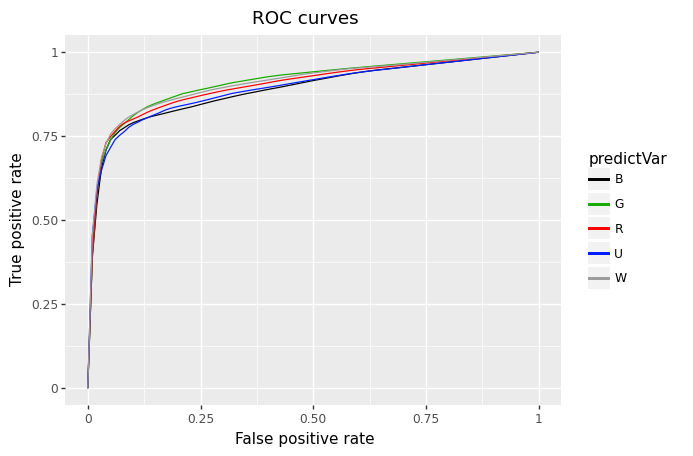

<ggplot: (-9223363243051721507)>

In [0]:
mean_curve_df = predict_keyword('G', cards_df)
for x in ['U', 'B', 'W', 'R']:
  mean_curve_df = pd.concat([mean_curve_df, predict_keyword(x, cards_df)])
mean_curve_df = mean_curve_df.groupby(['predictVar','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='predictVar')) +
    geom_line() +
    labs(title = "ROC curves",
         x = "False positive rate",
         y = "True positive rate")) + scale_color_manual(values=["#000000","#17ab00","#ff0000","#001eff","#9c9c9c"])

Above is a graph of ROC curves for predicting the color of a Creature based on its traits. The performance difference between colors is relatively small, which indicates that in general the variability of creatures within each color types is similar.

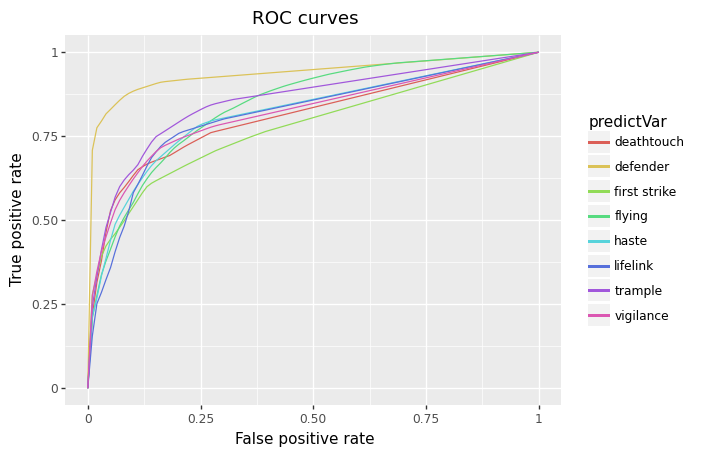

<ggplot: (8793802922742)>

In [0]:
mean_curve_df = predict_keyword('vigilance', cards_df)
for x in ['flying', 'deathtouch', 'trample', 'haste', 'lifelink', 'first strike', 'defender']:
  mean_curve_df = pd.concat([mean_curve_df, predict_keyword(x, cards_df)])
mean_curve_df = mean_curve_df.groupby(['predictVar','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='predictVar')) +
    geom_line() +
    labs(title = "ROC curves",
         x = "False positive rate",
         y = "True positive rate"))

Above is a graph of ROC curves for predicting whether a creature has a certain ability. There is significant variability in performance for predicting the different abilities. This shows that there that some creatures with certain abilities share more features than creatures with other abilities. An example of this would be that creatures with defender have more traits in common than creatures with first strike.

# **Conclusion**
In this tutorial we touch on data preperation, exploratory analysis and visualization,as well as machine learning and hypothesis testing. Through our analysis, we have learned that power creep is in fact a real trend even if its effects are small. We also explored card stats are related to cost and color in different ways. At the end, we were able to train models to predict the colors and abilities of different cards with a high degree of success.